In [ ]:
import torch
from PIL import Image
import sys, os
from torchvision import transforms
from diffusers import StableDiffusionPipeline
from omegaconf import OmegaConf
from tqdm import tqdm
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from base._pipeline import StableDiffusionXLPipeline
from base.data import load_data
from base.inpating_data import RandomCircularBlur,CompleteBlur,ScaleCircularBlur,DynamicBlur,Saliency
import numpy as np

os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'
device = torch.device("cuda:1")

In [ ]:
pipe = StableDiffusionXLPipeline.from_pretrained(pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0", use_safetensors=True) #torch_dtype=torch.float16, , variant="fp16" #14G GPU memory
pipe.to(device)
unet = pipe.unet
total_params = sum(p.numel() for p in unet.parameters())
total_params_million = total_params / 1e6
print(f"U-Net 参数量: {total_params_million:.2f}M 参数")
# model_id = "CompVis/stable-diffusion-v1-4"
# pipe = StableDiffusionPipeline.from_pretrained(model_id) #, torch_dtype=torch.float16) #6G GPU memory
# pipe.to(device)

In [14]:
config_path = '/home/wht/multimodal_brain/src/tasks/base/configs/debias_train.yaml'
config = OmegaConf.load(config_path)
config['ksize'] = None
config['sigmaX'] = None

train_loader, test_loader = load_data(config)



/home/wht/multimodal_brain/src/tasks/base/data.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(data_path)
/home/wht/multimodal_brain/src/tasks

init test_dataset success
init train_dataset success


In [15]:
images = train_loader.dataset.loaded_data[0]['img']
set_images = list(set(images))
set_images.sort()
batch_size = 8
image_z_dict = {}
data_dir = '/dev/shm/wht/datasets/things-eeg-small/Preprocessed_data_1000Hz_whiten'
to_tensor = transforms.ToTensor()
T = ScaleCircularBlur()

for i in tqdm(range(0, len(set_images), batch_size)):
    batch_images = set_images[i:i + batch_size]
    ele = [to_tensor(T(Image.open(os.path.join(data_dir,'../Image_set',img)).convert("RGB"))) for img in batch_images]

    img_tensor = torch.stack(ele).to(device)
    batch_img_z = pipe.vae.encode(img_tensor).latent_dist.sample()
    
    for i,img in enumerate(batch_images):
        image_z_dict[img]= batch_img_z[i].float().detach().cpu()
torch.save({'ldm_z':image_z_dict}, '/home/wht/multimodal_brain/datasets/things-eeg-small/Image_feature/ldm_train.pt')

100%|██████████| 2068/2068 [24:35<00:00,  1.40it/s]


In [25]:
keys = list(image_z_dict.keys())
keys[0]

'train_images/00001_aardvark/aardvark_01b.jpg'

In [33]:
for key in keys:
    # print(image_z_dict[key].shape)
    pass
print(image_z_dict[key].shape)

torch.Size([4, 62, 62])


In [ ]:
img_path = "figures/bird.jpg"
img = Image.open(img_path).convert("RGB")

img = T(img)
Image.fromarray(img)

In [ ]:
img_tensor = to_tensor(img).unsqueeze(0).to(device)
img_z = pipe.vae.encode(img_tensor).latent_dist.sample()
recon_img_tensor = pipe.vae.decode(img_z, return_dict=False)[0].permute(0, 2, 3, 1).cpu().detach().numpy()

In [20]:
recon_img_tensor.shape

(1, 496, 496, 3)

In [ ]:
recon_img = Image.fromarray((recon_img_tensor[0]*255).astype(np.uint8)) 
recon_img.save("figures/bird_blur_recon.png")
recon_img

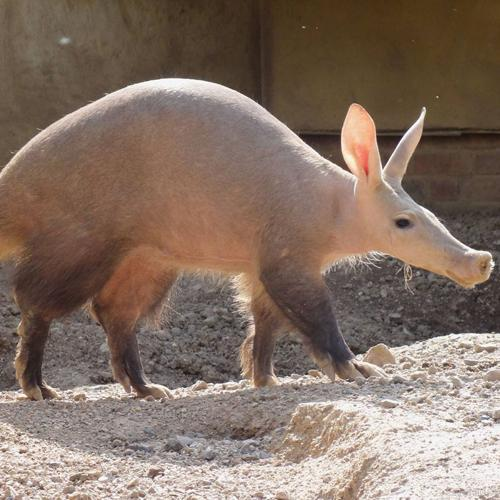

In [18]:
path = 'train_images/00001_aardvark/aardvark_01b.jpg'
Image.open(os.path.join(data_dir,'../Image_set',path)).convert("RGB")

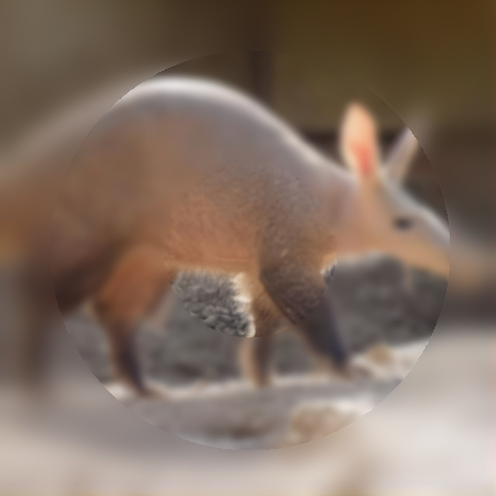

In [19]:
img_z = image_z_dict['train_images/00001_aardvark/aardvark_01b.jpg'].unsqueeze(0).to(device)
recon_img_tensor = pipe.vae.decode(img_z, return_dict=False)[0].permute(0, 2, 3, 1).cpu().detach().numpy()
recon_img = Image.fromarray((recon_img_tensor[0]*255).astype(np.uint8)) 
recon_img